In [2]:
import jittor as jt
import numpy as np
import matplotlib.pyplot as plt
from model import StyledGenerator, Discriminator
from dataset import SymbolDataset
from tqdm import tqdm

jt.flags.use_cuda = True
jt.flags.log_silent = True

### Test Discriminator

In [3]:
netD = Discriminator()
nsteps = 5
alpha = 0
batch_size = 16
for step in range(nsteps):
    image_size = 2**(step+2)
    print('Testing image of [%02d x %02d]' % (image_size, image_size))
    image = jt.rand(batch_size, 3, image_size, image_size)
    pred = netD(image, step, alpha)
    assert(pred.shape == [batch_size, 1])

Testing image of [04 x 04]
Testing image of [08 x 08]
Testing image of [16 x 16]
Testing image of [32 x 32]
Testing image of [64 x 64]


### Test Generator

In [4]:
netG = StyledGenerator()
nsteps = 5
alpha = 0
batch_size = 16
code_dim = 512
z = jt.randn(batch_size, code_dim)

for step in range(nsteps):
    image_size = 2**(step+2)
    print('Testing image of [%02d x %02d]' % (image_size, image_size))
    fake_image = netG(z, step=step, alpha=alpha, style_weight=0.5)
    assert(fake_image.shape == [batch_size, 3, image_size, image_size])

Testing image of [04 x 04]
Testing image of [08 x 08]
Testing image of [16 x 16]
Testing image of [32 x 32]
Testing image of [64 x 64]


### Test Dataset

In [5]:
import jittor.transform as transform

transform = transform.Compose([
    #transform.Resize(size=img_size),
    transform.ToPILImage(),
    transform.RandomHorizontalFlip(),
    transform.ToTensor(),
    transform.ImageNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 32
root_path = 'color_symbol_7k'
train_loader = SymbolDataset(root_path, transform, 16).set_attrs(batch_size=batch_size, shuffle=True)

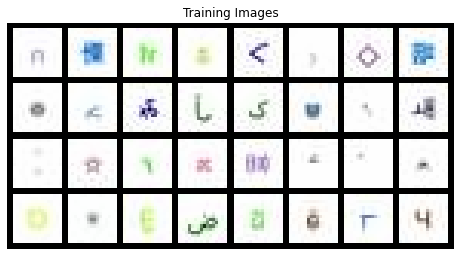

In [6]:
import torchvision.utils
import torch

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(torch.from_numpy(real_batch.numpy()), padding=2, normalize=True),(1,2,0)))

## Training

In [7]:
import math
import random

### Helper Functions

In [8]:
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].update(par1[k] * decay + (1 - decay) * par2[k].detach())

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

### Preset hyper-parameters

In [21]:
init_size = 8
max_size  = 64
init_step = int(math.log2(init_size) - 2)
max_step  = int(math.log2(max_size) - 2)
nsteps = max_step - init_step + 1

lr = 1e-3
mixing = True

code_size = 512
batch_size = {8: 256, 16: 128, 32: 64, 64: 32}
batch_default = 32
gen_sample = {512: (8, 4), 1024: (4, 2)}

phase = 1000
max_iter = 100

### Load Generator & Discriminator

In [22]:
netG = StyledGenerator(code_dim=code_size)
netD = Discriminator(from_rgb_activate=True)
g_running = StyledGenerator(code_size)
g_running.eval()

d_optimizer = jt.optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.99))
g_optimizer = jt.optim.Adam(
    netG.generator.parameters(), lr=lr, betas=(0.0, 0.99)
)
g_optimizer.add_param_group(
    {
        'params': netG.style.parameters(),
        'lr': lr * 0.01,
        'mult': 0.01,
    }
)

accumulate(g_running, netG, 0)

### Actual Training

In [23]:
step = init_step
resolution = int(4 * 2 ** step)
train_loader = SymbolDataset(root_path, transform, resolution).set_attrs(
    batch_size=batch_size.get(resolution, batch_default), 
    shuffle=True
)
train_loader = iter(train_loader)

requires_grad(netG, False)
requires_grad(netD, True)

disc_loss_val = 0
gen_loss_val = 0
grad_loss_val = 0

alpha = 0
used_sample = 0
final_progress = False
pbar = tqdm(range(max_iter))

for i in pbar:
    alpha = min(1, 1 / phase * (used_sample + 1))
    if resolution == init_size or final_progress:
        alpha = 1     

    if used_sample > phase * 2:
        used_sample = 0
        step += 1

        if step > max_step:
            step = max_step
            final_progress = True
            ckpt_step = step + 1
        else:
            alpha = 0
            ckpt_step = step

        resolution = 4 * 2 ** step

        train_loader = SymbolDataset(root_path, transform, resolution).set_attrs(
                batch_size=batch_size.get(resolution, batch_default), 
                shuffle=True
            )
        train_loader = iter(train_loader)

        jt.save(
            {
                'generator': netG.state_dict(),
                'discriminator': netD.state_dict(),
                'g_running': g_running.state_dict(),
            },
            f'checkpoint/train_step-{ckpt_step}.model',
        )
            
    real_image = next(train_loader)
    real_image.requires_grad = True
    b_size = real_image.size(0)
    
    real_scores = netD(real_image, step=step, alpha=alpha)
    real_predict = jt.nn.softplus(-real_scores).mean()
    
    grad_real = jt.grad(real_scores.sum(), real_image)
    grad_penalty = (
        grad_real.reshape(grad_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()
    grad_penalty = 10 / 2 * grad_penalty
    
    if i%10 == 0:
        grad_loss_val = grad_penalty.item()
    
    if mixing and random.random() < 0.9:
        gen_in11, gen_in12, gen_in21, gen_in22 = jt.randn(4, b_size, code_size).chunk(4, 0)
        gen_in1 = [gen_in11.squeeze(0), gen_in12.squeeze(0)]
        gen_in2 = [gen_in21.squeeze(0), gen_in22.squeeze(0)]
    else:
        gen_in1, gen_in2 = jt.randn(2, b_size, code_size).chunk(2, 0)
        gen_in1 = gen_in1.squeeze(0)
        gen_in2 = gen_in2.squeeze(0)
    
    fake_image = netG(gen_in1, step=step, alpha=alpha)
    fake_predict = netD(fake_image, step=step, alpha=alpha)
    fake_predict = jt.nn.softplus(fake_predict).mean()
    
    if i % 10 == 0:
        disc_loss_val = (real_predict + fake_predict).item()

    loss_D = real_predict + grad_penalty + fake_predict
    d_optimizer.step(loss_D)
    
    # optimize generator
    
    requires_grad(netG, True)
    requires_grad(netD, False)
    
    fake_image = netG(gen_in2, step=step, alpha=alpha)
    predict = netD(fake_image, step=step, alpha=alpha)
    loss_G = jt.nn.softplus(-predict).mean()
    
    if i % 10 == 0:
        gen_loss_val = loss_G.item()
            
    g_optimizer.step(loss_G)
    
    accumulate(g_running, netG)
    requires_grad(netG, False)
    requires_grad(netD, True)

    used_sample += real_image.shape[0]
    
    if (i + 1) % 100 == 0:
        images = []

        gen_i, gen_j = gen_sample.get(resolution, (10, 5))

        with jt.no_grad():
            for _ in range(gen_i):
                images.append(
                    g_running(
                        jt.randn(gen_j, code_size), step=step, alpha=alpha
                    ).data
                )

        jt.save_image(
            jt.concat(images, 0),
            f'sample/{str(i + 1).zfill(6)}.png',
            nrow=gen_i,
            normalize=True,
            range=(-1, 1),
        )

    if (i + 1) % 10000 == 0:
        jt.save(
            g_running.state_dict(), f'checkpoint/{str(i + 1).zfill(6)}.model'
        )

    state_msg = (
        f'Size: {4 * 2 ** step}; G: {gen_loss_val:.3f}; D: {disc_loss_val:.3f};'
        f' Grad: {grad_loss_val:.3f}; Alpha: {alpha:.5f}'
    )
    pbar.set_description(state_msg)


  0%|          | 0/100 [00:00<?, ?it/s]
Compiling Operators(19/20) used: 2.31s eta: 0.122s 20/20) used: 3.32s eta:    0s 

Compiling Operators(18/18) used: 3.32s eta:    0s 

Compiling Operators(29/32) used: 3.37s eta: 0.348s 32/32) used: 4.38s eta:    0s 

Compiling Operators(12/12) used: 3.33s eta:    0s 
Size: 8; G: 7.374; D: 0.603; Grad: 0.520; Alpha: 1.00000:   1%|          | 1/100 [00:19<31:43, 19.23s/it]
Compiling Operators(26/26) used: 3.36s eta:    0s 

Compiling Operators(12/12) used: 4.36s eta:    0s 

Compiling Operators(1/1) used: 2.61s eta:    0s 
Size: 8; G: 7.374; D: 0.603; Grad: 0.520; Alpha: 1.00000:   2%|▏         | 2/100 [00:30<27:25, 16.79s/it]
Compiling Operators(8/8) used: 3.31s eta:    0s 

Compiling Operators(8/8) used: 3.36s eta:    0s 
Size: 64; G: 7.272; D: 0.078; Grad: 0.011; Alpha: 1.00000:  99%|█████████▉| 99/100 [08:47<00:05,  5.33s/it] 


AttributeError: 'jittor_core.Var' object has no attribute 'cuda'

In [7]:
init_size = 8
code_size = 512
batch_size = 64
step = int(math.log2(init_size)) - 2
resolution = 4 * 2 ** step
train_loader = SymbolDataset(root_path, transform, resolution).set_attrs(batch_size=batch_size, shuffle=True)

disc_loss_val = 0
gen_loss_val = 0
grad_loss_val = 0

lr = 1e-3
alpha = 0
used_sample = 0
num_epoch = 100
mixing = True
phase = len(train_loader) * num_epoch // 2

d_optimizer = jt.optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.99))
g_optimizer = jt.optim.Adam(
        netG.generator.parameters(), lr=lr, betas=(0.0, 0.99)
    )
g_optimizer.add_param_group(
    {
        'params': netG.style.parameters(),
        'lr': lr * 0.01,
        'mult': 0.01,
    }
)

D_losses = []
G_losses = []
img_list = []

In [54]:
for epoch in range(num_epoch):
    
    for i, real_image in enumerate(train_loader):
        alpha = min(1, 1 / phase * (used_sample + 1))
        real_image.requires_grad = True
        real_scores = netD(real_image, step=step, alpha=alpha)
        real_predict = jt.nn.softplus(-real_scores).mean()
        #real_predict.backward(retain_graph=True)

        grad_real = jt.grad(real_scores.sum(), real_image)
        grad_penalty = (
            grad_real.reshape(grad_real.size(0), -1).norm(2, dim=1) ** 2
        ).mean()
        grad_penalty = 10 / 2 * grad_penalty
        #grad_penalty.backward()
        
        if mixing and random.random() < 0.9:
            gen_in11, gen_in12, gen_in21, gen_in22 = jt.randn(4, batch_size, code_size).chunk(4, 0)
            gen_in1 = [gen_in11.squeeze(0), gen_in12.squeeze(0)]
            gen_in2 = [gen_in21.squeeze(0), gen_in22.squeeze(0)]
        else:
            gen_in1, gen_in2 = jt.randn(2, batch_size, code_size).chunk(2, 0)
            gen_in1 = gen_in1.squeeze(0)
            gen_in2 = gen_in2.squeeze(0)
        
        fake_image = netG(gen_in1, step=step, alpha=alpha)
        fake_predict = netD(fake_image, step=step, alpha=alpha)
        fake_predict = jt.nn.softplus(fake_predict).mean()
        #fake_predict.backward()
        loss_D = real_predict + grad_penalty + fake_predict
        d_optimizer.step(loss_D)
        
        fake_image = netG(gen_in2, step=step, alpha=alpha)
        predict = netD(fake_image, step=step, alpha=alpha)
        loss_G = jt.nn.softplus(-predict).mean()
        g_optimizer.step(loss_G)
        
        used_sample += real_image.shape[0]
        
        if i % 50 == 0:
            print('[%03d/%d][%03d/%d] Loss_D: %.4f\tLoss_G: %.4f'
                  % (epoch + 1, num_epoch, i, len(train_loader)//batch_size,
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())
    
    img_list.append(fake_image)

[001/100][000/217] Loss_D: 1.4306	Loss_G: 0.6661
[001/100][050/217] Loss_D: 1.3807	Loss_G: 0.7329
[001/100][100/217] Loss_D: 1.3799	Loss_G: 0.7063
[001/100][150/217] Loss_D: 1.3781	Loss_G: 0.7268
[001/100][200/217] Loss_D: 1.3389	Loss_G: 0.7722
[002/100][000/217] Loss_D: 1.3720	Loss_G: 0.7628
[002/100][050/217] Loss_D: 1.3697	Loss_G: 0.6478
[002/100][100/217] Loss_D: 1.3307	Loss_G: 0.6989
[002/100][150/217] Loss_D: 1.3425	Loss_G: 0.6882
[002/100][200/217] Loss_D: 1.3828	Loss_G: 0.6932
[003/100][000/217] Loss_D: 1.3563	Loss_G: 0.7704
[003/100][050/217] Loss_D: 1.3513	Loss_G: 0.7931
[003/100][100/217] Loss_D: 1.3600	Loss_G: 0.7390
[003/100][150/217] Loss_D: 1.3253	Loss_G: 0.7107
[003/100][200/217] Loss_D: 1.3705	Loss_G: 0.7169
[004/100][000/217] Loss_D: 1.3724	Loss_G: 0.7448
[004/100][050/217] Loss_D: 1.3458	Loss_G: 0.7900
[004/100][100/217] Loss_D: 1.3626	Loss_G: 0.8614
[004/100][150/217] Loss_D: 1.3423	Loss_G: 0.7761
[004/100][200/217] Loss_D: 1.3533	Loss_G: 0.7508
[005/100][000/217] L

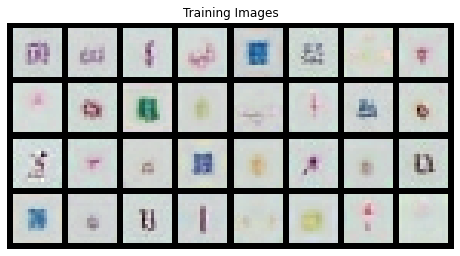

In [71]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(torch.from_numpy(img_list[299].numpy()), padding=2, normalize=True),(1,2,0)))